# Fine-tuning SmolVLM with GRPO and SFT for improve object understanding

## Load Libs

In [24]:
import datasets
import torch
from PIL import Image
from transformers.image_utils import load_image
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration, AutoModelForVision2Seq, TrainingArguments, Trainer
import json
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
from trl import GRPOTrainer, GRPOConfig

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import wandb
from datasets import load_dataset

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import gc

model = None
processor = None

In [25]:
def clear_model_data(model, processor):
    try:
        del model
        print("delete model")
    except:
        pass
    try:
        del processor  
        print("delete processor")
    except:
        pass

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

## Checking the zero-shot capabilities of the SmolVLM

### Make dataset

You need to create train data:

``` bash
conda activate rlvla_env
cd RL4VLA/ManiSkill
cuda=0

CUDA_VISIBLE_DEVICES=$cuda \
python -m mani_skill.examples.motionplanning.widowx.collect_simpler \
  -e "PutOnPlateInScene25Single-v1" \
  --save_video --save_data --num_procs 1 --num_traj 75 --seed=0
```

In [33]:
def load_data_from_npz(path = None, num_of_samples = None):
    '''Parce episode data files, extract only first, mid and end data'''
    if path is None:
        raise ValueError("You're not send path")
    
    npz_files = [f for f in os.listdir(path) if f.find('.npz') != -1]

    if num_of_samples != None:
        npz_files = npz_files[0:num_of_samples]

    files = {}
    
    for file in npz_files:
        file_path = path + "/" + file
        
        with np.load(file_path, allow_pickle=True) as data:
            mid_index = int(len(data["arr_0"].item()["info"])/2)

            file_summary = {
                "first_iter": {"data": data["arr_0"].item()["info"][0], "image": data["arr_0"].item()["image"][0]},
                "mid_iter": {"data": data["arr_0"].item()["info"][mid_index], "image": data["arr_0"].item()["image"][mid_index]},
                "last_iter": {"data": data["arr_0"].item()["info"][-1], "image": data["arr_0"].item()["image"][-1]},
                "first_iter_QA": {},
                "mid_iter_QA": {},
                "last_iter_QA": {},
            }

            files[f"{file}"] = file_summary

    return files


def load_data_from_npz_general(path = None, num_of_samples = None, filename = False):
    '''Parce every frame in collected episodes'''
    if path is None:
        raise ValueError("You're not send path")
    
    if filename:
        npz_files = [f for f in os.listdir(path) if f.find(filename) != -1]
    else:
        npz_files = [f for f in os.listdir(path) if f.find('.npz') != -1]

    if num_of_samples != None:
        npz_files = npz_files[0:num_of_samples]

    files = {}
    
    for file in npz_files:
        file_path = path + "/" + file
        file_summary = {}

        with np.load(file_path, allow_pickle=True) as data:
            for i in range(len(data["arr_0"].item()["info"])):
                file_summary[f"{i}_frame"] = {
                    "data": data["arr_0"].item()["info"][i], 
                    "image": data["arr_0"].item()["image"][i], 
                    f"QA": {},
                    }

            files[f"{file}"] = file_summary

    return files

In [ ]:
carrot_on_plate_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data", num_of_samples=20)
spoon_on_table_clothin_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutSpoonOnTableClothInScene-v1/75/data", num_of_samples=10)

In [ ]:
carrot_on_plate_file_one_episode = load_data_from_npz_general("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data", num_of_samples=1)
spoon_on_table_file_one_episode = load_data_from_npz_general("./RL4VLA/ManiSkill/mp_collect/PutSpoonOnTableClothInScene-v1/75/data", filename = "success_proc_0_numid_19_epsid_20.npz")

{'elapsed_steps': array([34], dtype=int32), 'moved_correct_obj': array([False]), 'moved_wrong_obj': array([False]), 'is_src_obj_grasped': array([ True]), 'consecutive_grasp': array([ True]), 'src_on_target': array([ True]), 'success': array([ True])}


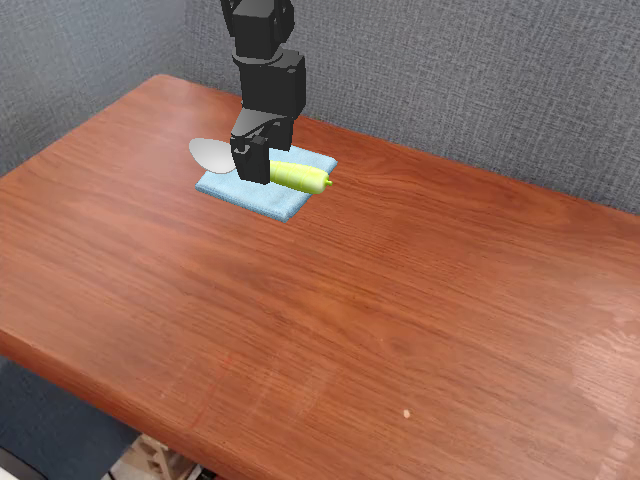

In [9]:
n = 33

print(spoon_on_table_file_one_episode["success_proc_0_numid_19_epsid_20.npz"][f"{n}_frame"]["data"])
spoon_on_table_file_one_episode["success_proc_0_numid_19_epsid_20.npz"][f"{n}_frame"]["image"]

### Zero-shot model evaluation

In [26]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11491.24it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


In [27]:
questions_list = [
    "What objects are in the scene?",
    "Where is objects relative to each other?", #"Where is the carrot relative to the plate?",
    "Is the carrot on the plate?",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
]


def collect_answers(data, questions_list, model, processor):
    '''Collect answers for the every question in the question_list and group it by filename'''

    data_len = len(data) 

    collecting_data_loop = tqdm(enumerate(data.items()), leave=True)
    
    iters = [
        "first_iter",
        "mid_iter",
        "last_iter"
    ]

    for i, (filename, filename_data) in collecting_data_loop:
        # Prepare inputs

        for question in questions_list:
            
            message = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
            ]


            prompt = processor.apply_chat_template(message, add_generation_prompt=True)
            for Iter in iters:
                inputs = processor(text=prompt, images=[filename_data[Iter]["image"]], return_tensors="pt")
                inputs = inputs.to(DEVICE)

                # Generate outputs
                generated_ids = model.generate(**inputs, max_new_tokens=500)
                generated_text = processor.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                )

                answer = generated_text[0].split("Assistant: ")[-1]

                filename_data[Iter + "_QA"][question] = answer
                
                
            collecting_data_loop.set_description(f"collecting data from {i+1}/{data_len} file: {filename}")


def collect_answers_general(data, questions_list, model, processor):
    '''Collect answers for the every question in the question_list and group it by filename'''

    data_len = len(data) 

    collecting_data_loop = tqdm(enumerate(data.items()), leave=True)

    for j, (filename, filename_data) in collecting_data_loop:
        # Prepare inputs

        for question in questions_list:
            
            message = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
            ]
               
            prompt = processor.apply_chat_template(message, add_generation_prompt=True)
            for i in range(len(filename_data)):
                inputs = processor(text=prompt, images=[filename_data[f"{i}_frame"]["image"]], return_tensors="pt")
                inputs = inputs.to(DEVICE)

                # Generate outputs
                generated_ids = model.generate(**inputs, max_new_tokens=500)
                generated_text = processor.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                )

                answer = generated_text[0].split("Assistant: ")[-1]

                filename_data[f"{i}_frame"]["QA"][question] = answer
                
                
            collecting_data_loop.set_description(f"collecting data from {j+1}/{data_len} file: {filename}")

In [12]:
questions_list = [
    "What objects are in the scene?",
    "Where is objects relative to each other?", 
    "Is the carrot on the plate?",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
    "Is the carrot on the plate? Yes/No.",
    "Is the orange object (carrot) on the yellow plate in this image? Yes/No.",
    "Is the orange object on the yellow object in this image? Yes/No.", 
]

collect_answers(carrot_on_plate_files, questions_list, model=model, processor=processor)

with open('carrot_on_plate_FML.pkl', 'wb') as f: #First Mid Last
    pickle.dump(carrot_on_plate_files, f)

collect_answers_general(carrot_on_plate_file_one_episode, questions_list, model=model, processor=processor)

with open('carrot_on_plate_one_episode.pkl', 'wb') as f: 
    pickle.dump(carrot_on_plate_file_one_episode, f)

questions_list = [
    "What objects are in the scene?",
    "Where is objects relative to each other?", 
    "Is the spoon on the clothin? Yes/No.",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
    "Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No.",
    "Is the green/yellow object on the blue object in this image? Yes/No.",
]

collect_answers(spoon_on_table_clothin_files, questions_list, model=model, processor=processor)

with open('spoon_on_table_clothin_files_FML.pkl', 'wb') as f: 
    pickle.dump(spoon_on_table_clothin_files, f)

collect_answers_general(spoon_on_table_file_one_episode, questions_list, model=model, processor=processor)

with open('spoon_on_table_file_one_episode.pkl', 'wb') as f: 
    pickle.dump(spoon_on_table_file_one_episode, f)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [25:13, 75.66s/it]
collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [14:22, 862.20s/it]
collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [10:59, 65.98s/it]
collecting data from 1/1 file: success_proc_0_numid_19_epsid_20.npz: : 1it [12:26, 746.40s/it]


In [36]:
with open('carrot_on_plate_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files = pickle.load(f)

with open('carrot_on_plate_one_episode.pkl', 'rb') as f: 
    carrot_on_plate_file_one_episode = pickle.load(f)

with open('spoon_on_table_file_one_episode.pkl', 'rb') as f: 
    spoon_on_table_file_one_episode = pickle.load(f)

with open('spoon_on_table_clothin_files_FML.pkl', 'rb') as f: 
    spoon_on_table_clothin_files = pickle.load(f)

#### Let's first look at the general questions and evaluate the extent to which the model can perceive semantic connections

In [47]:
counter = 0
carrot_counter = 0
for _, item in carrot_on_plate_files.items():
    counter+=2
    print(item["last_iter_QA"]["Is there an object that can be eaten?"])
    if item["last_iter_QA"]["Is there an object that can be eaten?"].find("carrot") != -1:
        carrot_counter+=1
    print(item["first_iter_QA"]["Is there an object that can be eaten?"])
    if item["first_iter_QA"]["Is there an object that can be eaten?"].find("carrot") != -1:
        carrot_counter+=1

Yes, there is a food item on the table.
Yes, there is a carrot on the plate.
Yes, there is a carrot on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is a carrot in the image.
Yes, there is a carrot in the image.
Yes, there is a fruit in the image.
Yes, there is a carrot in the image.
Yes, there is a food item on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is a carrot and an orange on the table.
Yes, there is a carrot on the table.
Yes, there is a carrot on the table.
Yes, there is a carrot and a vegetable in the image.
Yes, there is a carrot on the table.
Yes, there is a carrot on the table.
Yes, there is a food item in the image.
Yes, there is a carrot on the table.
Yes, there is a fruit on the table.
Yes, there is a carrot in the image.
Yes, there is a carrot on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is an orange in the image.
Yes, there is a carrot on the table.
Yes, the

As you can see, the model understands that there is an edible object in the image, but it doesn't always recognize the object as a carrot. The model also sometimes perceives the carrot leaves as separate objects.

In [48]:
print(float(carrot_counter/counter))

0.75


['Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding', 'Holding'] ['Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding', 'Is not holding']


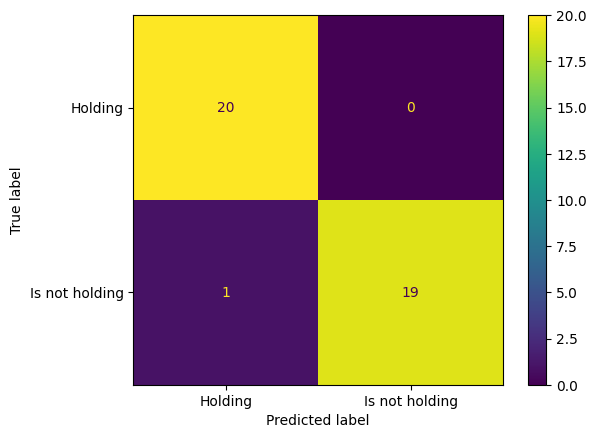

In [45]:
Hold_carrot = ["Holding"]*20
Is_not_hold_carrot = ["Is not holding"]*20
targets = Hold_carrot + Is_not_hold_carrot

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("Holding" if item["last_iter_QA"]["Is the gripper holding an object?"].lower().find("yes") != -1 else "Is not holding")
    preds_not_on_the_plate.append("Holding" if item["first_iter_QA"]["Is the gripper holding an object?"].lower().find("yes") != -1 else "Is not holding")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["Holding", "Is not holding"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Holding", "Is not holding"])

disp.plot()

The model also understands when a carrot is clamped in the grip of the manipulator.

### Question - Carrot on plate

['carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate'] ['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate']


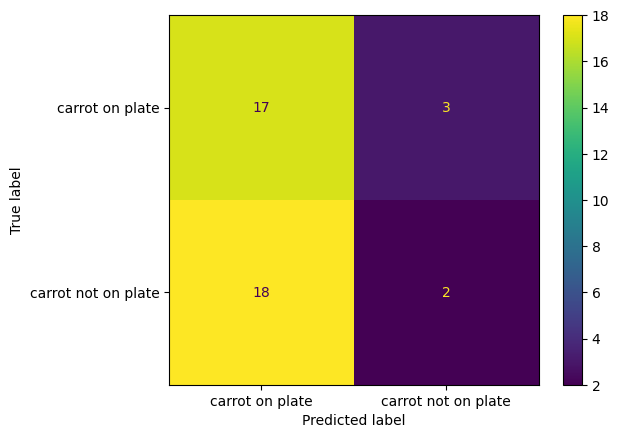

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()
    

In [ ]:
question = ["Is the carrot on the plate? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

0it [00:00, ?it/s]

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [03:26, 10.31s/it]


['carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate'] ['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate']


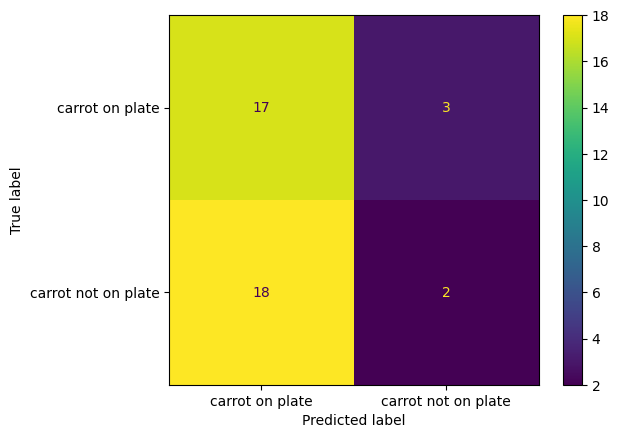

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

#### As you can see, the original model almost always thinks the carrot is on the plate. This is probably because it generalizes between the plate and the table. Let's try to improve the metrics by rephrasing the question.

In [ ]:
question = ["Is the orange object (carrot) on the yellow plate in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:35,  7.80s/it]


['carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate'] ['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate']


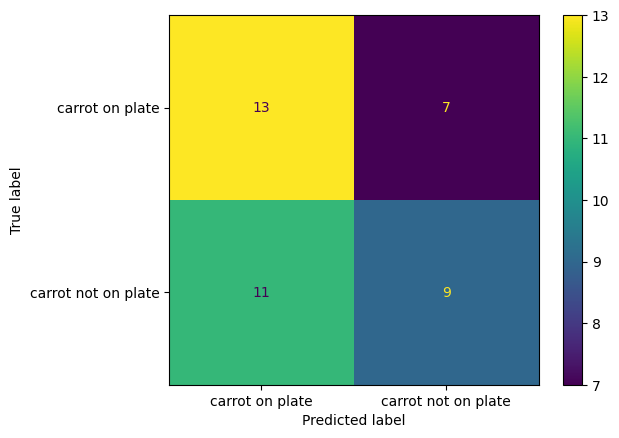

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object (carrot) on the yellow plate in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object (carrot) on the yellow plate in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

The performance has improved. There's a suspicion that the original VLM relies more heavily on the color representation of an object than on its general name.

In [16]:
question = ["Is the orange object on the yellow object in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:34,  7.73s/it]


['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate']


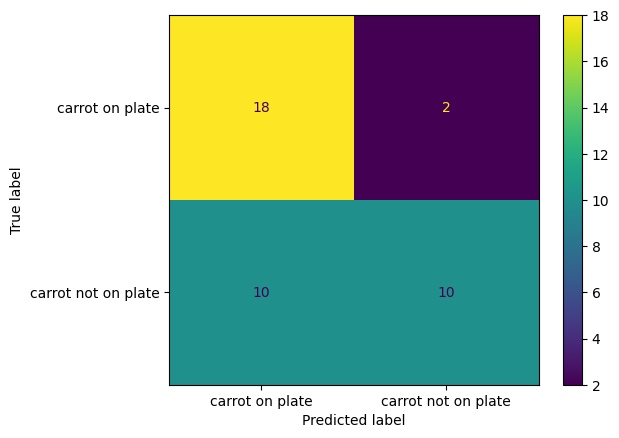

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object on the yellow object in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object on the yellow object in this image? Yes/No."].lower().find("yes") != -1 else "carrot not on plate")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

We conclude that for a pre-trained model, it is more appropriate to ask about the relationship between objects based on their color, rather than their actual names.

##### Let's see how the model performs in one episode.

In [30]:
question = ["Is the carrot on the plate?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:46, 106.10s/it]


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on pla

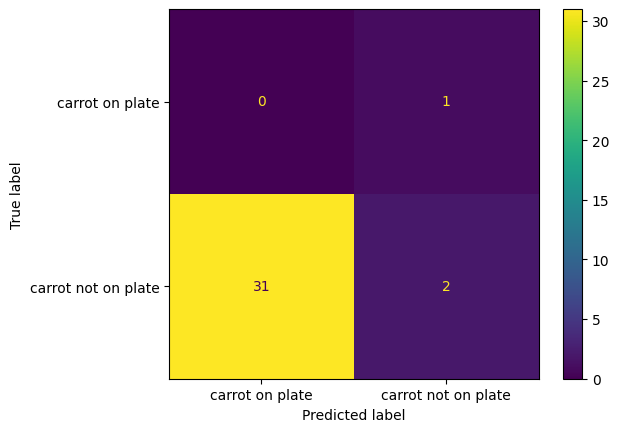

In [32]:
targets = []
preds = []


for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        preds.append("carrot on plate" if item[f"{i}_frame"]["QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
        targets.append("carrot on plate" if item[f"{i}_frame"]["data"]["src_on_target"] else "carrot not on plate")
print(preds, targets)

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

### Question - spoon on clothin

In [ ]:
question = [
    "Is the spoon on the clothin? Yes/No.",
    "Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No.",
    "Is the green/yellow object on the blue object in this image? Yes/No."
            ]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:18,  7.89s/it]


['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


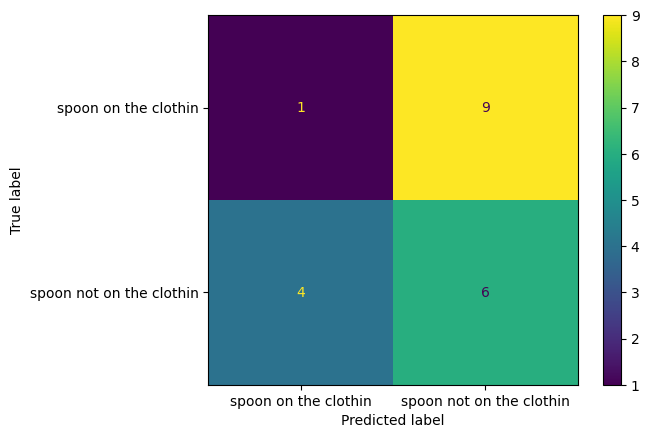

In [ ]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the spoon on the clothin? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the spoon on the clothin? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

['spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


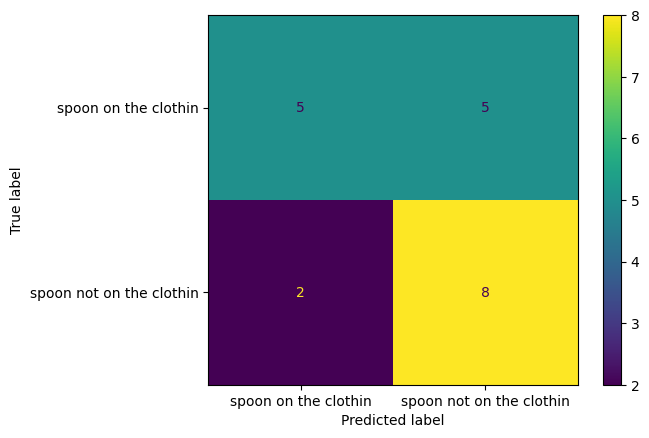

In [ ]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

['spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


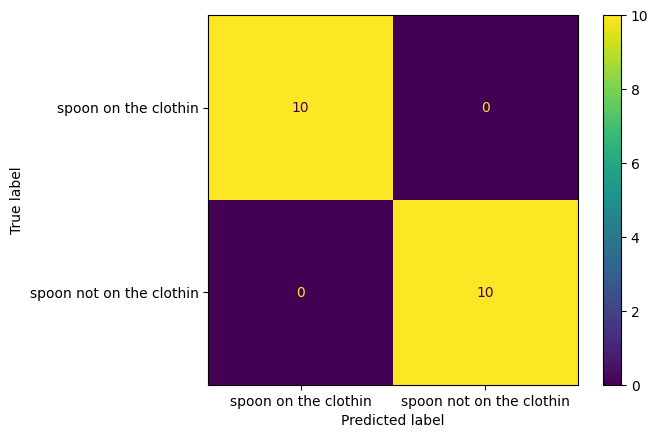

In [ ]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the green/yellow object on the blue object in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the green/yellow object on the blue object in this image? Yes/No."].lower().find("yes") != -1 else "spoon not on the clothin")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

#### As we can see from the obtained data, the hypothesis about color recognition of objects has been confirmed once again.

## SFT Train

### Make dataset

In [ ]:
def convert_ndarrays(obj):
        '''
        ndarray -> lists (for json transfer)
        '''
        if isinstance(obj, dict):
            return {k: convert_ndarrays(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_ndarrays(v) for v in obj]
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj

def build_jsonl_from_first_and_last_SFT(data, questions, answer_key, output_file=None):
    os.makedirs("./images", exist_ok=True)

    assert output_file != None, "Set the output filename!"
    counter = 0

    with open(output_file, "w", encoding="utf-8") as f:
        for question in questions:
            for _, item in data.items():

                img_first = f"./images/first_iter_{question}_{counter}.png"
                item["first_iter"]["image"].save(img_first)
                img_first = os.path.relpath(img_first)

                img_last = f"./images/last_iter_{question}_{counter}.png"
                item["last_iter"]["image"].save(img_last)
                img_last = os.path.relpath(img_last)

                sample = {
                    "image": img_first,  
                    "question": question, 
                    "answer": "yes" if item["first_iter"]["data"][answer_key] else "no",
                    "data": convert_ndarrays(item["first_iter"]["data"]),
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                sample = {
                    "image": img_last,  
                    "question": question,
                    "answer": "yes" if item["last_iter"]["data"][answer_key] else "no",
                    "data": convert_ndarrays(item["last_iter"]["data"]),
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                counter+=1

    
    print(f"Saved {counter*2} samples to {output_file}")
    return output_file

def build_jsonl_from_general_data(data, output_file=None):
    os.makedirs(f"./dataset_images", exist_ok=True)

    assert output_file != None, "Set the output filename!"
    counter = 0

    with open(output_file, "w", encoding="utf-8") as f:
        for filename, item in data.items():
            # print(filename.split(".npz")[0])
            dir_name = f"./dataset_images/{filename.split(".npz")[0]}"
            os.makedirs(dir_name, exist_ok=True)
            for i in range(len(item)):

                img = f"{dir_name}/{i}_frame_image.png"
                item[f"{i}_frame"]["image"].save(img)
                img = os.path.relpath(img)

                sample = {
                    "image": img,  
                    "data": convert_ndarrays(item[f"{i}_frame"]["data"]), 
                    # "answer": "yes" if item["first_iter"]["data"][answer_key] else "no"
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
            
                counter+=1
    
    print(f"Saved {counter} samples to {output_file}")
    return output_file

In [11]:
questions = [
    "Is the carrot on the plate?",
    "Is the carrot placed on the plate?",
    "Has the carrot been put on the plate?",
]
qa_dataset_file = build_jsonl_from_first_and_last_SFT(carrot_on_plate_files, questions, "src_on_target", "carrot_on_the_plate_dataset.jsonl")

Saved 120 samples to carrot_on_the_plate_dataset.jsonl


In [9]:
build_jsonl_from_general_data(carrot_on_plate_file_one_episode, output_file="carrot_on_plate_one_episode.jsonl")

Saved 34 samples to carrot_on_plate_one_episode.jsonl


'carrot_on_plate_one_episode.jsonl'

In [14]:
df = pd.read_json("carrot_on_the_plate_dataset.jsonl", lines=True)

df.to_json("train.jsonl", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={"train": "train.jsonl"}
)

Generating train split: 120 examples [00:00, 3659.69 examples/s]


### Model train

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

lora_config = LoraConfig(
    r=16,             
    lora_alpha=16,    
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],  
    lora_dropout=0.1,
    use_dora = True,
    init_lora_weights="gaussian",
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

model.add_adapter(lora_config)
model.enable_adapters()
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = Image.open(example["image"]).convert("RGB")
      question = example["question"]
      answer = example["answer"]
      messages = [
          {
              "role": "user",
              "content": [
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": answer}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

In [ ]:
model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=15,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit", 
    bf16=True, 
    output_dir=f"./{model_name}-carrots-and-plates",
    remove_unused_columns=False,
    gradient_checkpointing=True,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=processor,
)

trainer.train()

### Model evaluation

Make test data:

``` bash
conda activate rlvla_env
cd RL4VLA/ManiSkill
cuda=0

CUDA_VISIBLE_DEVICES=$cuda \
python -m mani_skill.examples.motionplanning.widowx.collect_simpler \
  -e "PutOnPlateInScene25Single-v1" \
  --save_video --save_data --num_procs 1 --num_traj 20 --seed=1

```

In [39]:
carrot_on_plate_files_test = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/20/data")

with open("carrot_on_plate_files_test_FML.pkl", "wb") as f:
    pickle.dump(carrot_on_plate_files_test, f)

In [28]:
with open('carrot_on_plate_files_test_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files_test = pickle.load(f)

In [29]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

fit_model_id = "MrAnton/smolvlm-sft-carrots" 

base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(base_model_id)

model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)


delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11650.84it/s]


#### Question - Carrot on plate

In [ ]:
questions = [
    "Is the carrot on the plate?",
    "Is the orange object on the yellow object in this image?",
    ]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

0it [00:00, ?it/s]

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [03:28, 10.45s/it]  


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


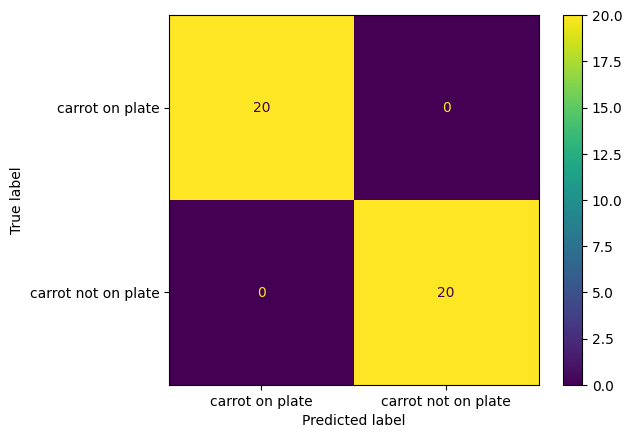

In [19]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files_test.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


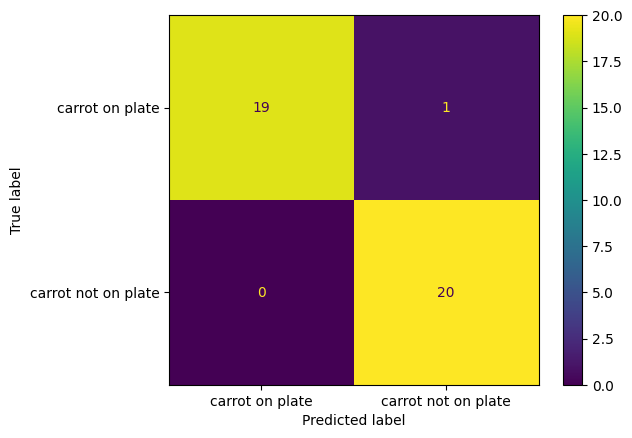

: 

In [ ]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files_test.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"]["Is the orange object on the yellow object in this image?"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"]["Is the orange object on the yellow object in this image?"].lower().find("yes") != -1 else "carrot not on plate")

print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

This suggests that fine-tuning the model has not been revealed in any way on the "Color perception" of objects, and even reinforce it.

In [25]:
question = ["Is the carrot on the plate?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:50, 110.69s/it]


['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot no

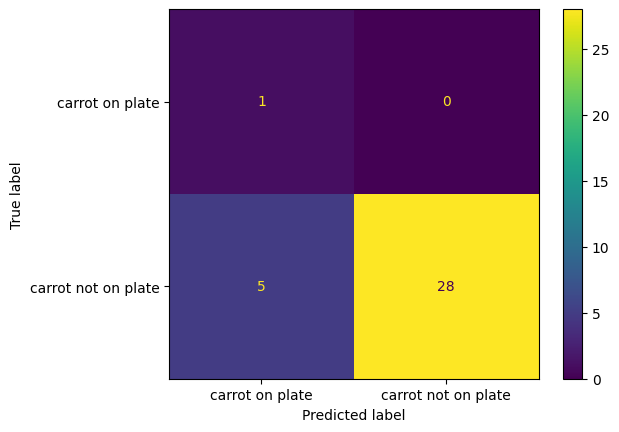

In [26]:
targets = []
preds = []


for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        preds.append("carrot on plate" if item[f"{i}_frame"]["QA"]["Is the carrot on the plate?"].lower().find("yes") != -1 else "carrot not on plate")
        targets.append("carrot on plate" if item[f"{i}_frame"]["data"]["src_on_target"] else "carrot not on plate")
print(preds, targets)

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

##### The model worked very well, but in this case, the last 6 pictures represent the intersection of the plate and the carrot, so the model thinks that the carrot is already on the plate.

In [28]:
for pred in preds:
    print(pred)

carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot on plate
carrot on plate
carrot on plate
carrot on plate
carrot on plate


Text(0.5, 1.0, 'yes')

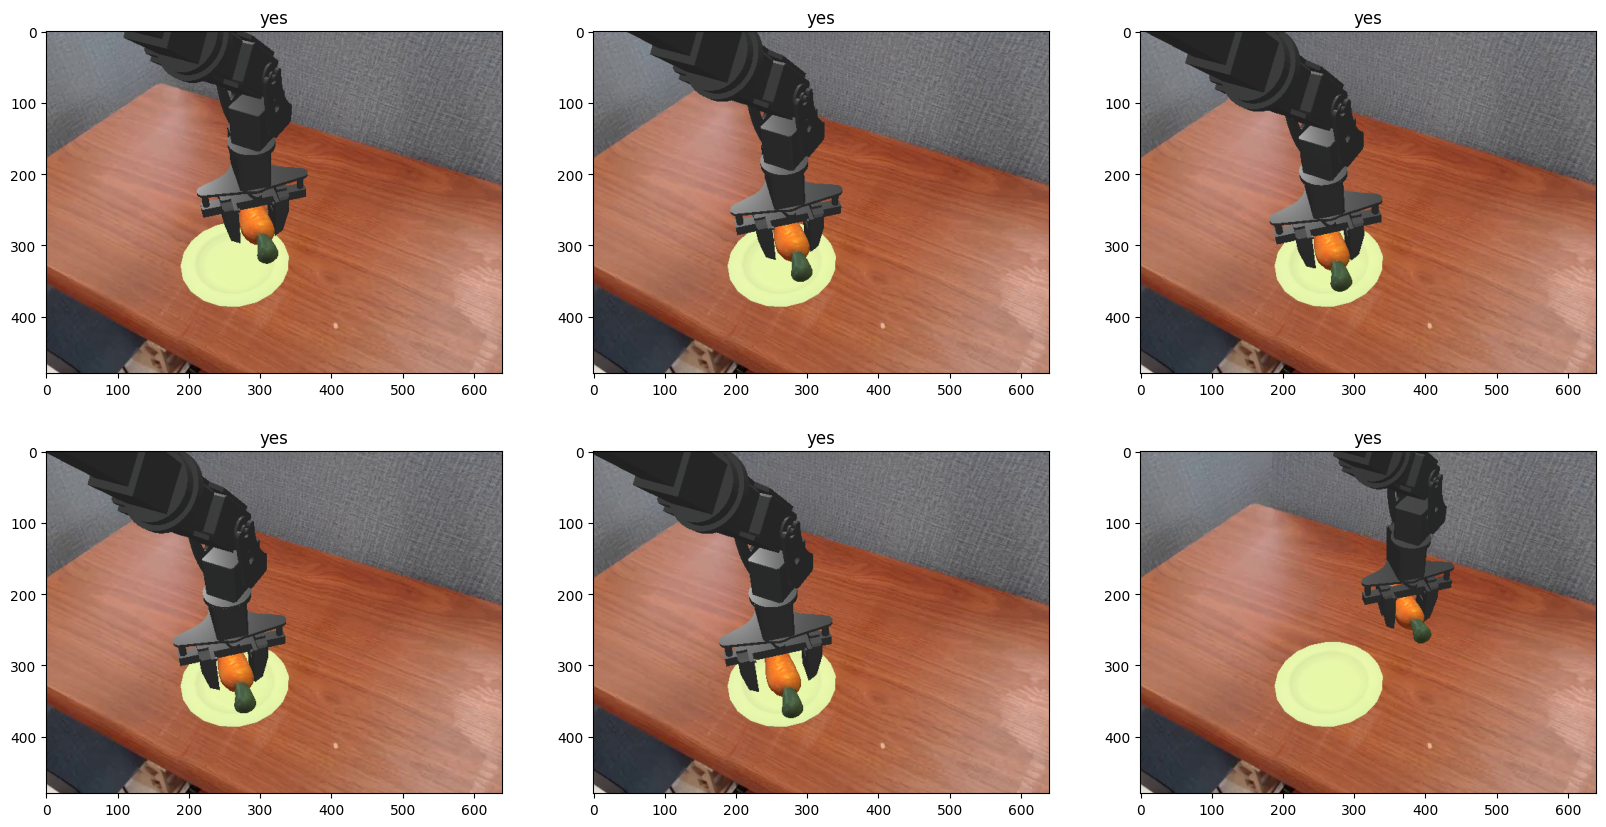

In [34]:
n = 33
fig = plt.figure(figsize=(20, 10))
for i in range(5):
    sub = fig.add_subplot(2, 3, i+1)
    sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["image"])
    sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["QA"]["Is the carrot on the plate?"])

sub = fig.add_subplot(2, 3, 6)
sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["image"])
sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["QA"]["Is the carrot on the plate?"])

In [ ]:
question = [
    "Is there an object that can be eaten?",
    "Is there an object that can be eaten? If yes, what is it?",
    ]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:52, 112.09s/it]


In [ ]:
for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        print(item[f"{i}_frame"]["QA"]["Is there an object that can be eaten?"])

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [8]:
for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        print(item[f"{i}_frame"]["QA"]["Is there an object that can be eaten? If yes, what is it?"])

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


Since all the data for the SFT contained only one token, it responded with only one token. To avoid this, a special system prompt should have been used, which will be demonstrated in the GRPO section.

The evaluation proves that the model now more or less understands what a carrot is and when it is on a plate.

### Question - spoon on clothin

In [43]:
question = ["Is the spoon on the clothin?"]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:40, 10.01s/it]


['spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


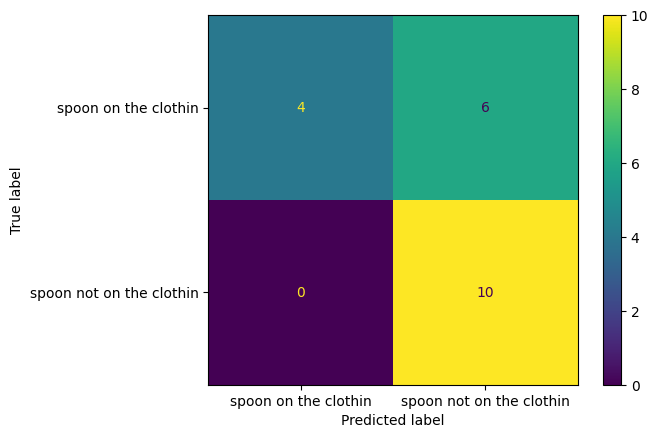

In [44]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

# print(targets)

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the spoon on the clothin?"].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the spoon on the clothin?"].lower().find("yes") != -1 else "spoon not on the clothin")
    
    # plt.imshow(item["last_iter"]["image"])
    # plt.axis("off")  
    # plt.show()
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

In [26]:
preds

['spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin']

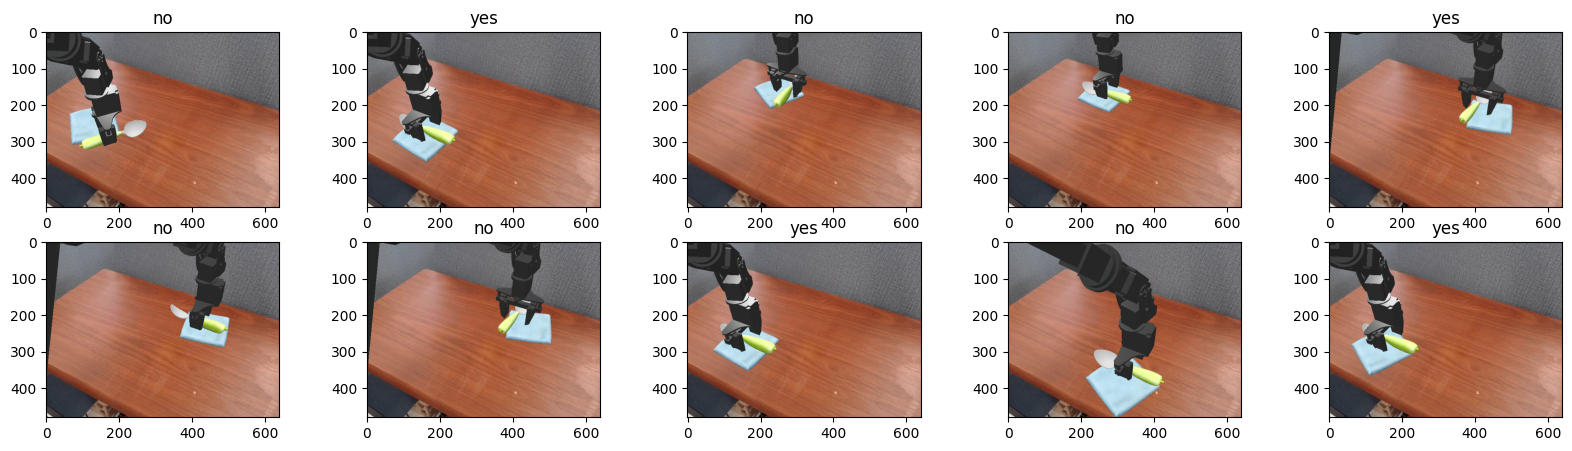

In [31]:
fig = plt.figure(figsize=(20, 5))
for i, (_, item) in enumerate(spoon_on_table_clothin_files.items()):
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(item["last_iter"]["image"])
    sub.set_title(item["last_iter_QA"]["Is the spoon on the clothin?"])

In [38]:
question = [
    "Is the green/yellow object on the blue object in this image?"
            ]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:38,  9.81s/it]


['spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


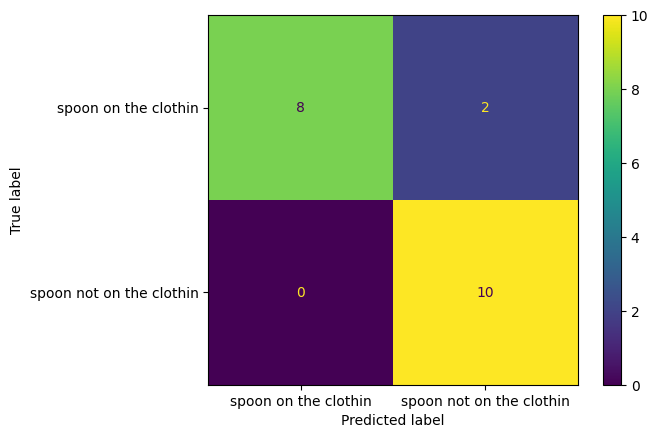

In [39]:
spoon_on_the_plate = ["spoon on the clothin"]*10
spoon_not_on_the_plate = ["spoon not on the clothin"]*10
targets = spoon_on_the_plate + spoon_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in spoon_on_table_clothin_files.items():
    preds_on_the_plate.append("spoon on the clothin" if item["last_iter_QA"]["Is the green/yellow object on the blue object in this image?"].lower().find("yes") != -1 else "spoon not on the clothin")
    preds_not_on_the_plate.append("spoon on the clothin" if item["first_iter_QA"]["Is the green/yellow object on the blue object in this image?"].lower().find("yes") != -1 else "spoon not on the clothin")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["spoon on the clothin", "spoon not on the clothin"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoon on the clothin", "spoon not on the clothin"])

disp.plot()

In [40]:
preds

['spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin']

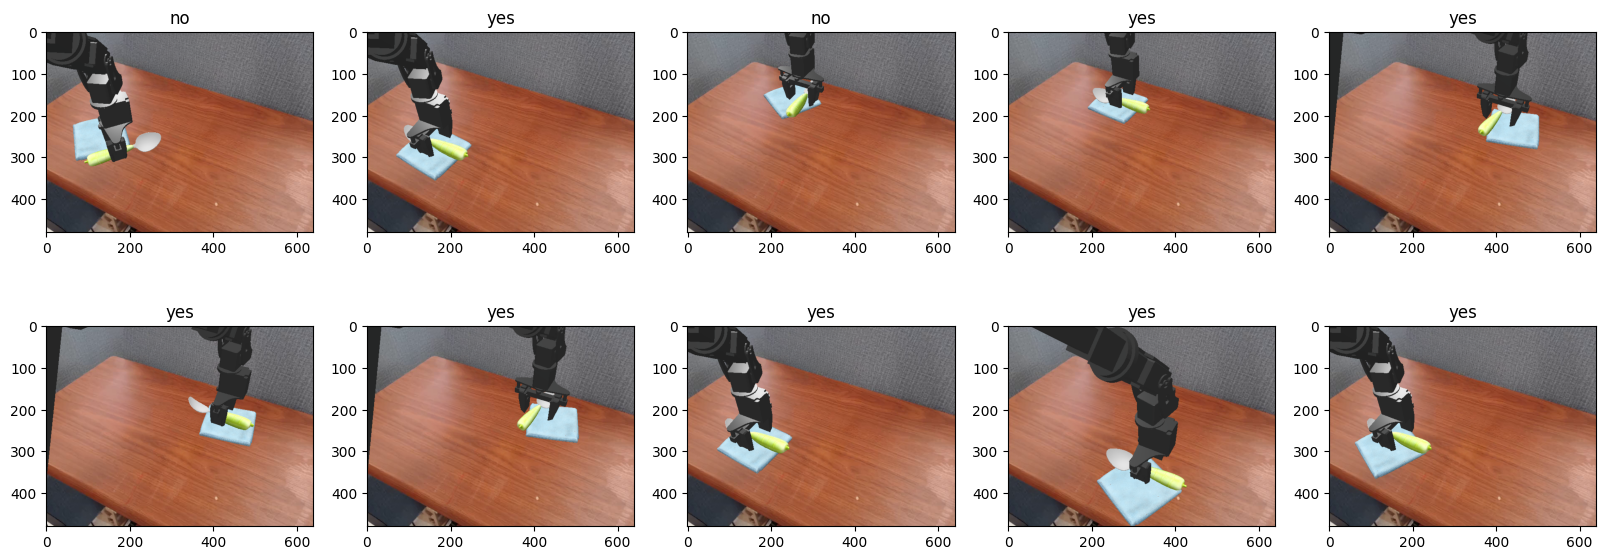

In [42]:
fig = plt.figure(figsize=(20, 7))
for i, (_, item) in enumerate(spoon_on_table_clothin_files.items()):
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(item["last_iter"]["image"])
    sub.set_title(item["last_iter_QA"]["Is the green/yellow object on the blue object in this image?"])

We can see that fine-tuning the model did not have much of harmful to the spoon-clothin task.

## GRPO Train

### Simple task: predict on the plate/not on the plate

#### Make a dataset:

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    _attn_implementation="eager", 
).to(DEVICE)

SYSTEM_PROMPT = (
    "Answer strictly in the format: "
    "yes/no"
)

def make_conversation(example):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": example["question"] + SYSTEM_PROMPT},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    return {
        "prompt": prompt,
        "image": example["image"],
        "labels": example["answer"], 
    }

dataset_grpo = dataset["train"].cast_column("image", datasets.Image(decode=True))
dataset_grpo = dataset_grpo.map(make_conversation)
dataset_grpo = dataset_grpo.remove_columns(["question", "answer", "data"])

#### Reward function

In [ ]:
def crt_on_plt_reward_function(completions, **kwargs):
    rewards = []
    labels = kwargs["labels"]  # ground truth answers

    for comp, label in zip(completions, labels):
        row_rewards = -10.0
        comp_lower = comp.lower()
        if "yes" in comp_lower and label == "yes":
            row_rewards = 1.0
        elif "no" in comp_lower and label == "no":
            row_rewards = 1.0
        
        rewards.append(row_rewards)

    print("COMP LIST: ", completions)
    print("ROW REWARDS: ", rewards)
    print("LABELS LIST: ", labels)
    return rewards

#### GRPO Train

In [ ]:
cfg = GRPOConfig(
    output_dir=f"./{model_id}_grpo_carrot_plate_yesno_task",
    learning_rate=1e-5,
    remove_unused_columns=False,  
    num_train_epochs=1,
    bf16=True,
   
    per_device_train_batch_size=2,
    max_completion_length=1,  
    num_generations=2,  
    max_prompt_length=2048,

    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,

    save_total_limit=1,

    report_to=[],
)

trainer = GRPOTrainer(
    model=model,
    processing_class=processor,
    reward_funcs=[crt_on_plt_reward_function],
    args=cfg,
    train_dataset=dataset_grpo,
)

trainer.train()

#### GRPO Model eval

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "MrAnton/SmolVLM-256M-Instruct_grpo_carrot_plate_yesno_task"
processor = AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


In [8]:
with open('carrot_on_plate_files_test_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files_test = pickle.load(f)

In [11]:
question_list = [
    f"Is the orange object on the yellow object in this image?{SYSTEM_PROMPT}",
    f"Is the orange object (carrot) on the yellow plate in this image?{SYSTEM_PROMPT}" ,
    f"Is the carrot on the plate?{SYSTEM_PROMPT}",
                 ]

collect_answers(carrot_on_plate_files_test, question_list, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [03:20, 10.05s/it]  


['carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


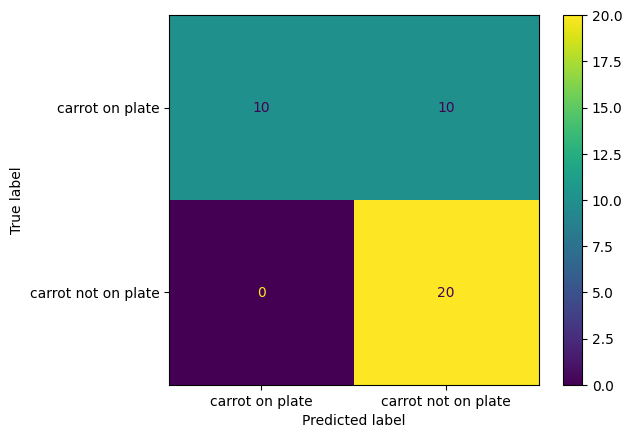

In [12]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files_test.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

### Teaching the model predict "Carrot on plate?" state and the distance between the carrot and the plate

#### Make a dataset:

In [ ]:
SYSTEM_PROMPT = (
    "Answer strictly in the format: "
    "yes/no, <number> "
    "Example: yes, 0.021 "
    "Example: no, 0.513 "
)

def make_conversation(example):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": example["question"] + SYSTEM_PROMPT},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    return {
        "prompt": prompt,
        "image": example["image"],
        "labels": example["answer"], 
        "dist_between_answer": example["data"]["carrot_plate_dist"]
    }

dataset_grpo = dataset["train"].cast_column("image", datasets.Image(decode=True))
dataset_grpo = dataset_grpo.map(make_conversation)
dataset_grpo = dataset_grpo.remove_columns(["question", "answer", "data"])

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map: 100%|██████████| 120/120 [00:01<00:00, 87.66 examples/s]


In [ ]:
print(dataset_grpo[0]["prompt"])

<|im_start|>User: Answer strictly in the format: yes/no, <number> Example: yes, 0.3 Example: no, 0 <image>Is the carrot on the plate?<end_of_utterance>
Assistant:


#### Create a warm-up model, using SFT, for teach the model predict right format (yes/no, dist):

In [ ]:
df = pd.read_json("carrot_on_the_plate_dataset.jsonl", lines=True)

df.to_json("warm_up_GRPO.jsonl", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={"train": "warm_up_GRPO.jsonl"}
)

Generating train split: 120 examples [00:00, 21722.77 examples/s]


In [16]:
round(dataset["train"]["data"][0]["carrot_plate_dist"][0], 3)

0.124

In [ ]:
number = "0.16"
float(number)

0.16

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

lora_config = LoraConfig(
    r=16,             
    lora_alpha=16,    
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],  
    lora_dropout=0.1,
    use_dora = True,
    init_lora_weights="gaussian",
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

model.add_adapter(lora_config)
model.enable_adapters()
# model = prepare_model_for_kbit_training(model)
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = Image.open(example["image"]).convert("RGB")
      question = example["question"]
      answer = example["answer"]
      dist = str(round(example["data"]["carrot_plate_dist"][0], 3))
      messages = [
          {
              "role": "user",
              "content": [
                  {"type": "image"},
                  {"type": "text", "text": question + SYSTEM_PROMPT}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": f"{answer}, {dist}"}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

In [ ]:
batch = collate_fn(dataset["train"])

<|im_start|>User: Answer strictly in the format: yes/no, <number> Example: yes, 0.02 Example: no, 0.51 <image>Is the carrot on the plate?<end_of_utterance>
Assistant: no, 0.12<end_of_utterance>



#### Train warm-up model

In [ ]:
model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    warmup_steps=5,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=15,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit", # for 8-bit, keep this, else adamw_hf
    bf16=True, # underlying precision for 8bit
    output_dir=f"./{model_name}-carrots-and-plates-GRPO-warmup",
    remove_unused_columns=False,
    gradient_checkpointing=True,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=grpo_warmup_dataset["train"],
    processing_class=processor,
)

trainer.train()

In [45]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

fit_model_id = "MrAnton/SmolVLM-256M-Instruct-carrots-and-plates-GRPO-warmup"

processor = AutoProcessor.from_pretrained(fit_model_id)

model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)

delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


In [46]:
with open('carrot_on_plate_files_test_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files_test = pickle.load(f)

#### Warm-up model evaluation

In [47]:
question = [f"Is the carrot on the plate?{SYSTEM_PROMPT}"]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [04:45, 14.30s/it]  


In [48]:
for _, item in carrot_on_plate_files_test.items():
    print(item["first_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"], item["first_iter"]["data"]["carrot_plate_dist"])

no, 0.102 [0.10050591]
yes, 0.027 [0.10042264]
no, 0.102 [0.12844403]
no, 0.102 [0.10118119]
no, 0.102 [0.09976418]
no, 0.102 [0.09677422]
no, 0.102 [0.16316684]
no, 0.102 [0.12243675]
no, 0.102 [0.12696698]
yes, 0.027 [0.12695055]
no, 0.102 [0.17757949]
no, 0.102 [0.16232416]
no, 0.102 [0.12772037]
no, 0.102 [0.15189087]
no, 0.102 [0.09639209]
no, 0.102 [0.13511255]
yes, 0.027 [0.09287106]
no, 0.102 [0.11054234]
no, 0.102 [0.17671199]
no, 0.102 [0.15259154]


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


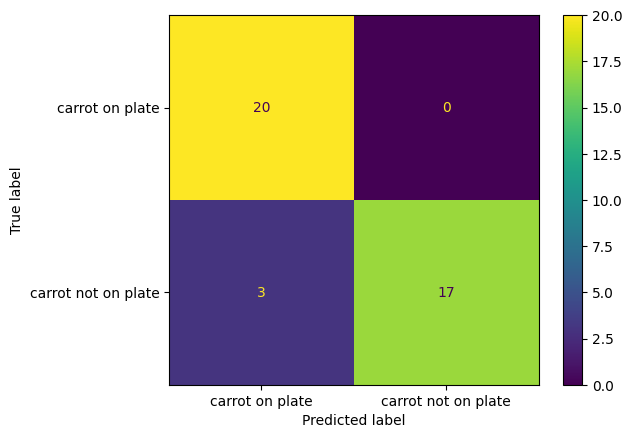

In [49]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files_test.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()

#### GRPO Train

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
model_id = "MrAnton/SmolVLM-256M-Instruct-carrots-and-plates-GRPO-warmup"

processor = AutoProcessor.from_pretrained(base_model_id, use_fast=True, padding_side='left')

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,             
    lora_alpha=8,    
    target_modules=['q_proj', 'v_proj'],  
    lora_dropout=0.1,
)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager", 
).to(DEVICE)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11831.61it/s]


trainable params: 755,712 || all params: 257,240,640 || trainable%: 0.2938


In [ ]:
def crt_on_plt_reward_function(completions, **kwargs):
    rewards = []
    labels = kwargs["labels"] 

    for comp, label in zip(completions, labels):
        row_rewards = 0.0
        comp_lower = comp.lower()
        if "yes" in comp_lower and label == "yes":
            row_rewards = 1.0
        elif "no" in comp_lower and label == "no":
            row_rewards = 1.0
        
        rewards.append(row_rewards)

    return rewards

def dist_between_plt_and_carrot(completions, **kwargs):
    gt_list = kwargs["dist_between_answer"]
    rewards = []

    for cand, gt in zip(completions, gt_list):
        match = re.search(r"[+]?\d*\.?\d+", str(cand))
        if match:
            pred_val = float(match.group(0))
            rewards.append(-(10*(pred_val - gt[0])**2)/(max(gt[0], 1e-6)**2))
        else:
            rewards.append(-15.0)
    
    return rewards

In [ ]:
completions = ["no, 0.1", "no, 0.6", "yes, 0.0"]

gt_list = [0.4, 0.4, 0.4]
rewards = []

for cand, gt in zip(completions, gt_list):
    match = re.search(r"[+]?\d*\.?\d+", str(cand))
    if match:
        pred_val = float(match.group(0))
        print(pred_val)
        rewards.append(-((pred_val - gt)**2)/(max(gt, 1e-6)**2))
    else:
        rewards.append(-15.0)
print(rewards)


0.1
0.6
0.0
[-0.5625, -0.24999999999999983, -1.0]


In [ ]:
cfg = GRPOConfig(
    output_dir=f"./{model_id}_grpo_simpler_task",
    learning_rate=1e-5,
    remove_unused_columns=False, 
    num_train_epochs=1,
    bf16=True,
    
    per_device_train_batch_size=2,
    max_completion_length=256, 
    num_generations=2,  
    max_prompt_length=2048,

    logging_steps=15,
    save_strategy="epoch",
    save_total_limit=1,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = GRPOTrainer(
    model=model,
    processing_class=processor,
    reward_funcs=[crt_on_plt_reward_function, dist_between_plt_and_carrot],
    args=cfg,
    train_dataset=dataset_grpo,
)

trainer.train()

In [52]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

fit_model_id = "MrAnton/SmolVLM-256M-Instruct-carrots-and-plates-GRPO-warmup_grpo_carrot_plate_dist_task"

# base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(fit_model_id)

model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)

delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]
Loading adapter weights from MrAnton/SmolVLM-256M-Instruct-carrots-and-plates-GRPO-warmup_grpo_carrot_plate_dist_task led to unexpected keys not found in the model: model.vision_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight, model.vision_model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight, model.vision_model.encoder.layers.0.self_attn.k_proj.lora_magnitude_vector.default.weight, model.vision_model.encoder.layers.0.self_attn.v_proj.lora_magnitude_vector.default.weight, model.vision_model.encoder.layers.0.self_attn.q_proj.lora_magnitude_vector.default.weight, model.vision_model.encoder.layers.1.self_attn.k_proj.lora_A.default.weight, model.vision_model.encoder.layers.1.self_attn.k_proj.lora_B.default.weight, model.vision_model.encoder.layers.1.self_attn.k_proj.lora_magnitude_vector.default.weight, model.vision_model.encoder.layers.1.self_attn.v_proj.lora_magnitude_vector.default.weight, model.vision

In [53]:
question = [f"Is the carrot on the plate?{SYSTEM_PROMPT}"]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [03:02,  9.12s/it]  


In [54]:
for _, item in carrot_on_plate_files_test.items():
    print(item["first_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"], item["first_iter"]["data"]["carrot_plate_dist"])

No. [0.10050591]
No. [0.10042264]
No. [0.12844403]
No. [0.10118119]
0.021. [0.09976418]
No. [0.09677422]
No. [0.16316684]
No. [0.12243675]
No. [0.12696698]
No. [0.12695055]
No. [0.17757949]
Answer: no. [0.16232416]
No. [0.12772037]
No. [0.15189087]
No. [0.09639209]
No. [0.13511255]
No. [0.09287106]
No. [0.11054234]
No. [0.17671199]
No. [0.15259154]


['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


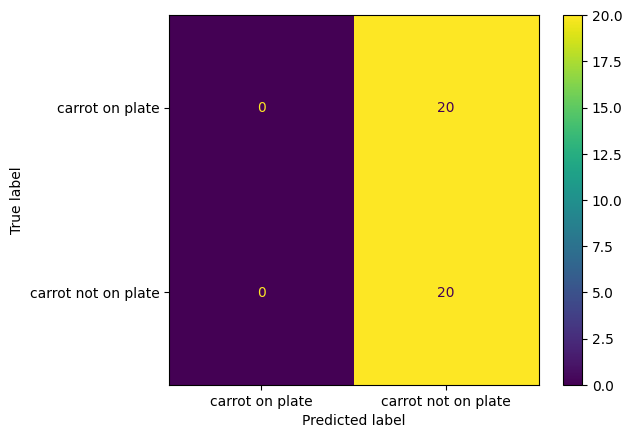

In [55]:
carrot_on_the_plate = ["carrot on plate"]*20
carrot_not_on_the_plate = ["carrot not on plate"]*20
targets = carrot_on_the_plate + carrot_not_on_the_plate

preds_on_the_plate = []
preds_not_on_the_plate = []


for _, item in carrot_on_plate_files_test.items():
    preds_on_the_plate.append("carrot on plate" if item["last_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"].lower().find("yes") != -1 else "carrot not on plate")
    preds_not_on_the_plate.append("carrot on plate" if item["first_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"].lower().find("yes") != -1 else "carrot not on plate")
    
print(preds_on_the_plate, preds_not_on_the_plate)
preds = preds_on_the_plate + preds_not_on_the_plate

cm = confusion_matrix(targets, preds, labels=["carrot on plate", "carrot not on plate"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["carrot on plate", "carrot not on plate"])

disp.plot()